# Modelling part 1

## 1. Import libraries and explore data

In [42]:
#import libraries
import pandas as pd
import numpy as np
import collections
import re
import sys
import time
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from itertools import islice
import pickle
from sklearn.model_selection import train_test_split

In [43]:
df = pd.DataFrame(pd.read_pickle('df_music'))

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              5100 non-null   int64  
 1   Song              5100 non-null   object 
 2   Artist            5100 non-null   object 
 3   Year              5100 non-null   int64  
 4   Lyrics            4913 non-null   object 
 5   Source            4913 non-null   float64
 6   Artists clean     5100 non-null   object 
 7   artist_song1      5100 non-null   object 
 8   songs_clean       5100 non-null   object 
 9   artist_song2      5100 non-null   object 
 10  danceability      5083 non-null   object 
 11  energy            5083 non-null   object 
 12  key               5083 non-null   object 
 13  loudness          5083 non-null   object 
 14  mode              5083 non-null   object 
 15  speechiness       5083 non-null   object 
 16  acousticness      5083 non-null   object 


In [45]:
df.shape

(5100, 29)

## 2. Drop songs without or with missing lyrics

In [46]:
# drop rows with missing values

df = df[df.Lyrics != " NA "]
df.dropna( how='any', subset=['Lyrics'], inplace=True)
#reset index
df.reset_index(inplace=True, drop=True)
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4897


In [47]:
#remove songs that are instrumental

df=df[df['Lyrics']!='instrumental'] 
df=df[df['Lyrics']!=' instrumental'] 
df=df[df['Lyrics']!=' instrumental '] 
df=df[df['Lyrics']!='instrumental ']
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4878


## 3. Clean lyrics and tokenize

In [48]:
# clean lyrics - remove punctuation


In [49]:
lyrics=[]

for lyric in df.Lyrics: 
    lyric_string=re.sub('[^A-Za-z]+', ' ', lyric)
    lyrics_string = re.sub('/\s\s+/g', ' ', lyric)
    lyrics.append(lyric_string.lstrip())


In [50]:
# apply wordninja as some lyrics have words crunched together in one string
lyrics_clean=[]
for lyric in lyrics :
    string=wordninja.split(lyric)
    title=""
    for s in string:
        title+=s+" " 
    lyrics_clean.append(title.strip())

In [51]:
#add to df
df['lyrics_clean']=lyrics_clean

In [52]:
#apply lemmatizer and tokenizer
# apply word tokenizer, delete stopwords, and apply lemmatizer
tokens=[]
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for row in lyrics_clean:
    row_tokens=word_tokenize(row)
    filtered_sent = [w for w in row_tokens if not w.lower() in stop_words]
    stemmed = [lemmatizer.lemmatize(word) for word in filtered_sent]
    tokens.append(stemmed)
df['tokens']=tokens

## 4. Make more features

In [84]:
# get types of words per song by POS tagging
from nltk.tag import pos_tag
import nltk 
nltk.download('tagsets')


[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\freudenreich\AppData\Roaming\nltk_data...


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data]   Unzipping help\tagsets.zip.


In [124]:
type(nltk.help.upenn_tagset())

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

NoneType

In [125]:
#list of pos tags per text
def get_pos(text):
    pos=[]
    for i in range(len(text)):
        pos.append(pos_tag(text)[i][1])
    return dict(pd.Series(pos).value_counts())


In [126]:
test_df=df[0:2]
test_df

,Rank,Song,Artist,Year,Lyrics,Source,Artists clean,artist_song1,songs_clean,artist_song2,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,error,lyrics_clean,tokens
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,sam the sham and the pharaohs,sam the sham and the pharaohs wooly bully,wooly bully,sam the sham and the pharaohs wooly bully,...,audio_features,0SRkuudTEWe2HOloI1Nssq,spotify:track:0SRkuudTEWe2HOloI1Nssq,https://api.spotify.com/v1/tracks/0SRkuudTEWe2...,https://api.spotify.com/v1/audio-analysis/0SRk...,138867,4,NaN,sam the sham miscellaneous wooly bully wooly b...,"[sam, sham, miscellaneous, wooly, bully, wooly..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,four tops,four tops i cant help myself sugar pie honey b...,i cant help myself sugar pie honey bunch,four tops i cant help myself sugar pie honey b...,...,audio_features,6b6IMqP565TbtFFZg9iFf3,spotify:track:6b6IMqP565TbtFFZg9iFf3,https://api.spotify.com/v1/tracks/6b6IMqP565Tb...,https://api.spotify.com/v1/audio-analysis/6b6I...,160280,4,NaN,sugar pie honey bunch you know that i love you...,"[sugar, pie, honey, bunch, know, love, cant, h..."


In [127]:

pos_count=test_df.tokens.apply(get_pos)


In [128]:
pos_count

0    {'NN': 24, 'JJ': 21, 'RB': 18, 'VBP': 9, 'CD':...
1    {'NN': 61, 'JJ': 13, 'VB': 11, 'RB': 6, 'VBP':...
Name: tokens, dtype: object

In [77]:
#include features for word difficulty 
#!pip install syllables
import syllables

import spacy

from textstat.textstat import textstatistics, legacy_round

def syllables_count(word):
    return syllables.estimate(word)
 
# Returns the average number of syllables per word in the text
def avg_syllables_per_word(text):
    syllable = syllables_count(text)
    words = word_count(text)
    ASPW = float(syllable) / float(words)
    return legacy_round(ASPW, 1)

# Return total no of Difficult Words in a text (difficult words are those with syllables >= 2)
    # a list of common words)
def difficult_words(text):
    diff_words_set = set()  
    nlp = spacy.load('en_core_web_sm')
    #doc = nlp(text)
    
    for word in text:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)
 
# Count of  polysyllablic words (if word has more than 3 syllables)

def poly_syllable_count(text):
    count = 0
  
    for word in text:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count
 



In [80]:
df.polysyl_count=df.lyrics_clean.apply(poly_syllable_count)
df.difficult_count=df.lyrics_clean.apply(difficult_words)


KeyboardInterrupt: 

In [70]:
df.polysyl_count.describe()

count    4878.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: lyrics_clean, dtype: float64

In [ ]:
#make plot of no of diffulct words difficulty by chart ranking
import seaborn as sns
sns.set_theme(style="whitegrid")
df_grouped=df["Rank", "difficult_count"].groupby(by=["Rank"]).mean()
ax = sns.barplot(x="Rank", y="difficult_count", data=df)


In [12]:
# more features

#get no of unique words per song lyric
count_words=[]
for row in df.tokens:
    unique = set(row) 
    count_words.append(len(unique))
#and add to df
df["unique_words"]=count_words

#keep only rows where no of words !=0
df=df[df['unique_words']!=0]
df.shape[0]

4831

In [13]:
##get total no of words per song lyric
total_words=[]
for row in df.tokens:
    length = len(row) 
    total_words.append(length)
df['total_words']=total_words

In [14]:
## get avg word length
word_length=[]
for row in df.tokens:
    length_row = len(row)
    length_word=sum([len(word) for word in row])/length_row
    word_length.append(length_word)
df['word_length']=word_length

In [15]:
## rhyming words

#!pip install phyme

In [16]:
from Phyme import Phyme

ph = Phyme()

In [17]:
# find number of words per song that are perfect rhymes 
#perfect rhymes. DOG -> COG
def get_rhymes(word):
    list_dict=[value for key,value in ph.get_perfect_rhymes(word).items()]
    all_rhymes=[]
    for row in list_dict:
        for word in row:
            all_rhymes.append(word)
    all_rhymes=list(set(all_rhymes))
    return all_rhymes
    
def count_rhymes(text):
    rhyme_count=0
    for word in list(set(text)):
        try:
            all_rhymes=get_rhymes(word) # get list of all words that rhyme
            for x in all_rhymes: # for each of these words, check if it is contained in the lyrics
                if x in text:
                    rhyme_count+=1
                else: 
                    pass
        except:
            pass
    return rhyme_count          
        

In [18]:
#apply functions to lists of lyric tokens
count_rhyming_words=[]
for lyric in df.tokens:
    count=count_rhymes(lyric)
    count_rhyming_words.append(count)

In [19]:
df['count_rhyming_words']=count_rhyming_words

In [20]:
#apply tfidf vectorizer after count vecotizer with n_gram_range==5

In [21]:
#count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(tokens):
    return tokens

cv = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 1)
    )  
tokens=df.tokens
x = cv.fit_transform(tokens)
words = cv.get_feature_names()
len(words)


16118

In [22]:
#tfidf vectorizer 
vectorizer = TfidfVectorizer(tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 1))

X_tfidf = vectorizer.fit(tokens.values) 

idf_scores = X_tfidf.idf_


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [23]:
#make histogram of idf scores
maxi=np.max(idf_scores)
mean=np.mean(idf_scores)
min=np.min(idf_scores)
print(maxi, mean, min)
len(idf_scores)

8.789868559054707 7.843214233681948 1.4558656327818755


16118

<AxesSubplot:ylabel='Count'>

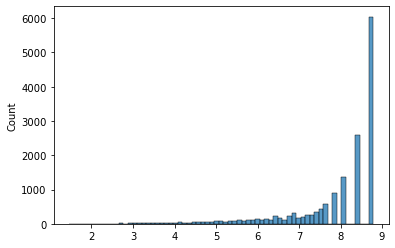

In [24]:
import seaborn as sns
sns.histplot(data=idf_scores)


In [25]:
X_tfidf.get_feature_names()[:10]

['aaa',
 'aaaa',
 'aaaaaa',
 'aaliyah',
 'aami',
 'aap',
 'ab',
 'aba',
 'abaca',
 'abandon']

In [26]:
#filter out ngrams that occur in too few or too many songs

filtered_indices = np.argwhere(((idf_scores>6) ))
filtered_indices = [idx[0] for idx in filtered_indices]

#list of vocabulary from the vectorizer
vocabulary = X_tfidf.get_feature_names()

#preparing a list with filtered vocabulary
filtered_voc = [vocabulary[i] for i in filtered_indices]

#size before and after filtering
print("no of words before filtering: ", len(idf_scores))
print("no of words after filtering: ", len(filtered_indices))

no of words before filtering:  16118
no of words before filtering:  14596


In [27]:
filtered_voc[:10]

['aaa',
 'aaaa',
 'aaaaaa',
 'aaliyah',
 'aami',
 'aap',
 'ab',
 'aba',
 'abaca',
 'abandon']

In [28]:
#keep only filtered indices
X_tfidf=vectorizer.fit_transform(tokens.values)[:,filtered_indices]
type(X_tfidf)
print(X_tfidf.shape)

(4831, 14596)


## 4. Tf-idf feature selection using tuned random forests

In [29]:
#random forest model
#define parameter grid for randomized search with forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#n_estimators
n_estimators = [250,300, 350]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_estimators':n_estimators}


In [30]:
def rf_rs(X_train, X_test, y_train, y_test):

    #Instantiate the classifier
    rf=RandomForestClassifier(n_jobs=-1)
    rs=RandomizedSearchCV(rf,random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    return rs

In [31]:
# fit tuned model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def fit_tuned_rf_model(model):
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)

    modelCV=RandomForestClassifier(max_features=model.best_params_['max_features'], max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'], min_samples_leaf=model.best_params_['min_samples_leaf'], bootstrap=model.best_params_['bootstrap'],n_estimators=model.best_params_['n_estimators'])
    modelCV.fit(X_train, y_train)

    #return predicted probabilities
    probs = modelCV.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    roc_auc=roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    print("Fitted tuned random forest model ", roc_auc)
    return modelCV, roc_auc, fpr, tpr

In [44]:
#save labels: ranking<50=1, 0 otherwise
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])
df['y']=y
df[['y','Rank']].groupby('y').mean()
len(y)
df.Rank.groupby(y).mean()

Rank
1    25.435178
0    75.410959
Name: Rank, dtype: float64

In [45]:
#Random forest classifier on tfidf features
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.7min finished


In [46]:
# save the tuned model to disk
filename = 'tuned_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [47]:
#fit tuned model
rf_fit=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
ROC AUC : 0.5057136083918782
Fitted tuned random forest model  0.5319788197032745


In [48]:
#plot most important features
importance=rf_fit[0].feature_importances_
feat_dict=dict(zip(filtered_voc,importance))
sort={k: v for k, v in sorted(feat_dict.items(), reverse=True, key=lambda item: item[1])}
n_items=list(islice(sort.items(), 50))

In [49]:
coeffs=[round(i[1],5) for i in n_items]
indices=[i[0] for i in n_items]


<BarContainer object of 50 artists>

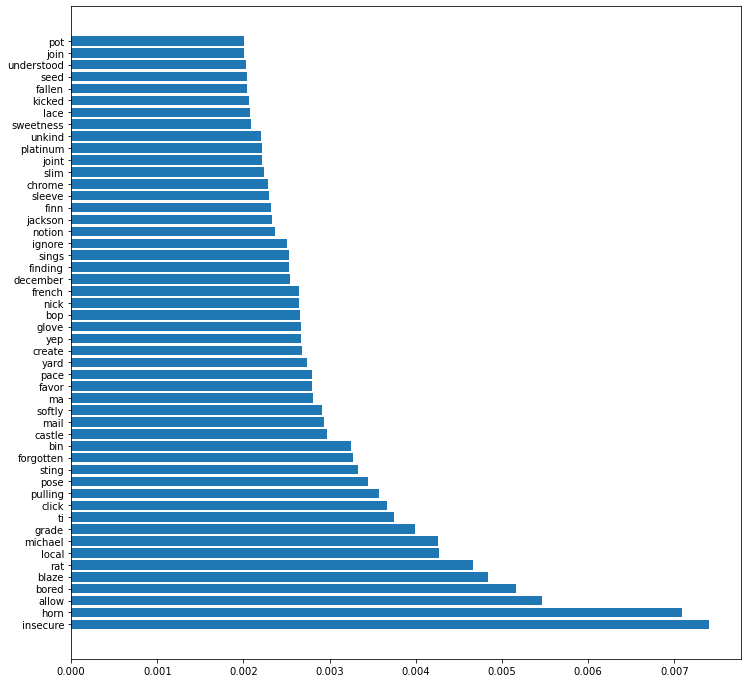

In [50]:
plt.figure(figsize=(12,12))
plt.barh(indices, coeffs)

In [52]:
#Select top 1000 features
top_1000=list(sort.items())[:1000]
top_1000_feat=[i[0] for i in top_1000]
#select top feat from X_tfidf
#get indices of top1000 features from filtered_voc
top_1000_indices = [i for i, value in enumerate(filtered_voc) if value in top_1000_feat]
X_1000=X_tfidf[:,top_1000_indices]
X_1000.shape

(4831, 1000)

## 5. Join music features, lyrics features and tfidf features

In [53]:
music_features=['danceability', 'key', 'loudness','energy','acousticness', 'speechiness', 'mode', 'instrumentalness', 'liveness','valence', 'tempo']
X_music=df[music_features]
X_music=X_music.fillna(X_music.mean())


In [54]:
#list of lyrics features

add_features=['word_length', 'unique_words', 'total_words','count_rhyming_words']

In [55]:
#join lyrics data with musical features
#stack sparse matrices
from scipy.sparse import hstack
import scipy.sparse

X_m=scipy.sparse.csr_matrix(X_music.values)
print(X_m.shape)

X_l=scipy.sparse.csr_matrix(df[add_features].values)


(4831, 11)
(4831, 4)


In [84]:
print(X_1000.shape)

(4831, 1000)


In [57]:
#array of column names
columns=filtered_voc+music_features+add_features
col_names = np.array(columns)
col_names

array(['aaa', 'aaaa', 'aaaaaa', ..., 'unique_words', 'total_words',
       'count_rhyming_words'], dtype='<U19')

In [85]:
X_text=hstack([X_1000, X_l])
X_all=hstack([X_text,X_m])

## 5. Build models

### Hyperparameter tuning

#### Logistic regression

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

In [66]:
#define parameter grid for logistic cv

C = [0.00001,0.0001, 0.001, 0.01, 0.1,1,10,100,1000, 10000]
penalty = ['l2']

parameters = dict(C=C, penalty=penalty)

In [67]:
def logistic_cv(X_train, X_test, y_train, y_test):
    logistic=LogisticRegression(max_iter=500)
    gsl=GridSearchCV(logistic, parameters, cv=3, n_jobs=-1, scoring="roc_auc")
    gsl.fit(X_train, y_train)
    return gsl

In [72]:
#fit tuned model
def fit_tuned_lr_model(model):    
    logisticCV=LogisticRegression(C=model.best_params_['C'], penalty=model.best_params_['penalty'], max_iter=500)
    logisticCV.fit(X_train, y_train)

    #return predicted probabilities
    lr_probs = logisticCV.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    roc_auc=roc_auc_score(y_test, lr_probs)
    fpr, tpr, _ = roc_curve(y_test, lr_probs)
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)
    print("Fitted tuned logit  model ", roc_auc)
    return logisticCV,roc_auc, fpr, tpr

In [91]:
#Logistic Classifier on tfidf features 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit=fit_tuned_lr_model(lr)
# save the tuned model to disk
filename = 'tuned_logistic_tfidf.sav'
pickle.dump(lr, open(filename, 'wb'))

tuned hyperparameters :(best parameters)  {'C': 1e-05, 'penalty': 'l2'}
ROC AUC : 0.5200311815949109
Fitted tuned logit  model  0.5100719639425422


In [79]:
#Logistic Classifier on tfidf top 1000 features only 
X_train, X_test, y_train, y_test = train_test_split(X_1000,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [80]:
#fit tuned model
lr_fit_1000=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 100, 'penalty': 'l2'}
ROC AUC : 0.6300352265176011
Fitted tuned logit  model  0.5382615109282657


In [ ]:
# save the tuned model to disk
filename = 'tuned_logistic_1000.sav'
pickle.dump(lr, open(filename, 'wb'))

In [86]:
#Logistic Classifier on tfidf top 1000 plus engineered text features  
X_train, X_test, y_train, y_test = train_test_split(X_text,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [87]:
# save the tuned model to disk
filename = 'tuned_logistic_text.sav'
pickle.dump(lr, open(filename, 'wb'))

In [88]:
#fit tuned model
lr_fit_text=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 1000, 'penalty': 'l2'}
ROC AUC : 0.625494894351135
Fitted tuned logit  model  0.5214295599442658


In [89]:
#Logistic Classifier on tfidf top 1000 plus engineered text features plus music features
X_train, X_test, y_train, y_test = train_test_split(X_all,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
#fit tuned model
lr_fit_all=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 10, 'penalty': 'l2'}
ROC AUC : 0.5421828895220934
Fitted tuned logit  model  0.5561219675596109


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random forest

In [92]:
#Random forest classifier on tfidf and text features
X_train, X_test, y_train, y_test = train_test_split(X_text,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


In [93]:
# save the tuned model to disk
filename = 'tuned_rf_only_text.sav'
pickle.dump(rf, open(filename, 'wb'))

In [94]:
#fit tuned model
rf_fit_text=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
ROC AUC : 0.5798305367078185
Fitted tuned random forest model  0.5394126823867622


In [95]:
#Random forest classifier on all 1000 tfidf plus text and musical features
X_train, X_test, y_train, y_test = train_test_split(X_all,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


In [96]:
# save the tuned model to disk
filename = 'tuned_rf_all.sav'
pickle.dump(rf, open(filename, 'wb'))

In [97]:
#fit tuned model
rf_fit_all=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
ROC AUC : 0.5729611493754975
Fitted tuned random forest model  0.5612943759298226


### SVM

In [101]:
#support vector mechines (SVM)
from sklearn.svm import SVC
#initiate model
svm = SVC(probability=True)

In [109]:
#tune hyperparameters with GridSearchCV
# defining parameter range
X_train, X_test, y_train, y_test = train_test_split(X_all,y, test_size=0.33, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_cv = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, scoring="roc_auc")
  
# fitting the model for grid search
svm_cv.fit(X_train, y_train)

print("Tuned SVM Params: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

Tuned SVM Params: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best score is 0.5474799511508267


In [110]:
#make model with tuned parameters
svm_tuned=SVC(C=svm_cv.best_params_['C'], gamma= svm_cv.best_params_['gamma'], kernel= svm_cv.best_params_['kernel'], probability=True)

In [111]:
svm_tuned.fit(X_train, y_train)

SVC(C=1, gamma=0.0001, probability=True)

In [112]:
svm_probs = svm_tuned.predict_proba(X_test)

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
roc_auc=roc_auc_score(y_test, svm_probs)
fpr, tpr, _ = roc_curve(y_test, svm_probs)

print("Fitted tuned svm model ", roc_auc)

Fitted tuned svm model  0.5422465771520774


## Evaluation

Model=LogisticRegression; Data=all tfidf features; ROC AUC=0.510
Model=RandomForestClassifier; Data=top 1000 tfidf features; ROC AUC=0.532
Model=RandomForestClassifier; Data=top tfidf plus text features; ROC AUC=0.539
Model=RandomForestClassifier; Data=all features; ROC AUC=0.561


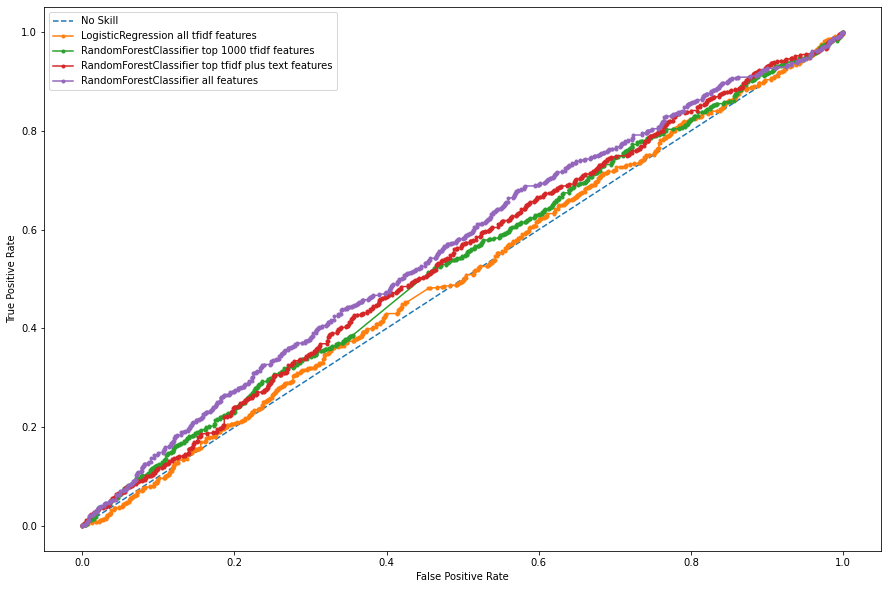

In [99]:
#drawing roc curve and auc


from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

## plot the roc curve: start with no skill prediction
fig, ax = plt.subplots(figsize=(15, 10))
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')


#draw roc curves for tuned models
def draw_roc_curve(model, label):
    model_name=type(model[0]).__name__
    # retrieve roc auc scores
    auc = model[1]
    # calculate roc curves
    # get tpr, fpr
    fpr=model[2]
    tpr=model[3]
    print('Model=%s; Data=%s; ROC AUC=%.3f' % (model_name, label, auc)) 
    lab=model_name+" "+label
    plt.plot(fpr, tpr, marker='.', label=lab)

    
model_dict={'all tfidf features':lr_fit_tfidf, 'top 1000 tfidf features': lr_fit_1000, 'top tfidf plus text features': lr_fit_text,'all features': lr_fit_all, 'top 1000 tfidf features': rf_fit, 'top tfidf plus text features': rf_fit_text,'all features': rf_fit_all}


#WHY CAN I NOT DRAW ALL LINES IN ONE GRAPH USING A LOOP?
for k,v in model_dict.items():
    draw_roc_curve(v,k)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
